In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
import sklearn
import gget

In [2]:
sc.settings.verbosity = 3  

In [3]:
fpath = "/scratch/indikar_root/indikar1/shared_data/single_cell_fibroblast/scanpy/raw.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names = adata.var['gene_name'].values
sc.logging.print_memory_usage()

adata

Memory usage: current 1.99 GB, difference +1.99 GB


AnnData object with n_obs × n_vars = 10883 × 19393
    obs: 'n_genes'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand'

# QC Vars and Plots

Running Scrublet
filtered out 4833 genes that are detected in less than 3 cells
filtered out 837 cells that have less than 3 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:01)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.05
Detected doublet rate = 73.4%
Estimated detectable doublet fraction = 93.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 78.8%
    Scrublet finished (0:01:52)


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:431: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


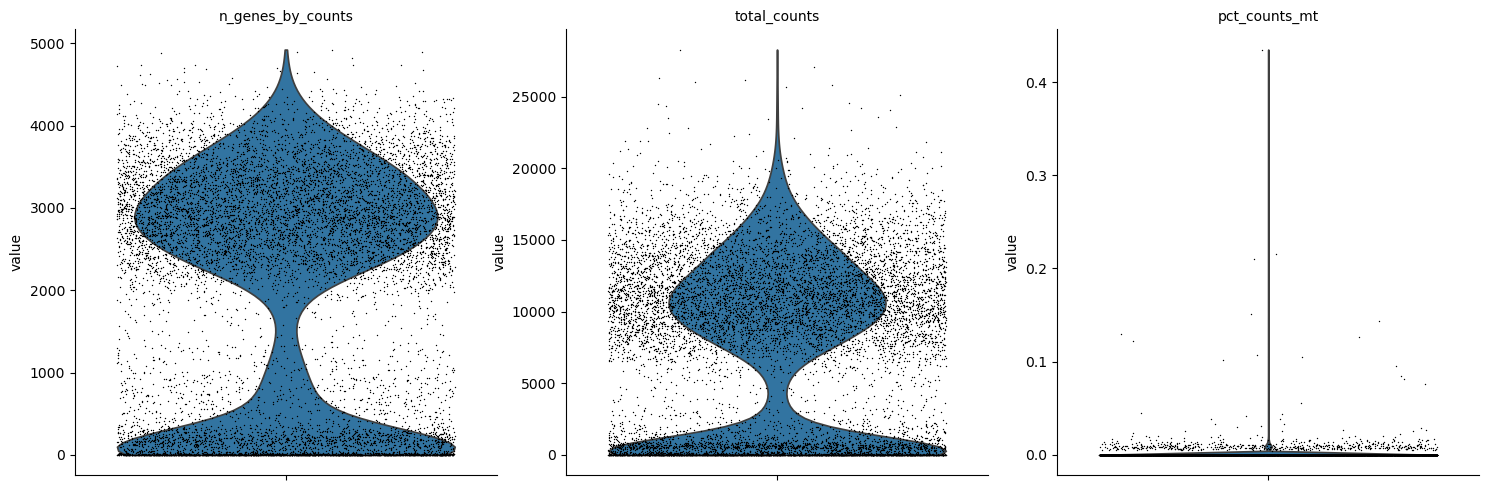

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.scrublet(
    adata
)

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [5]:
adata.obs['predicted_doublet'].value_counts()

predicted_doublet
True     7370
False    2676
Name: count, dtype: int64

# Filtering, Normalization and Variance Stabilization

In [6]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

# filtration
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

filtered out 1890 cells that have less than 100 genes expressed
filtered out 4833 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


normalizing counts per cell
    finished (0:00:00)


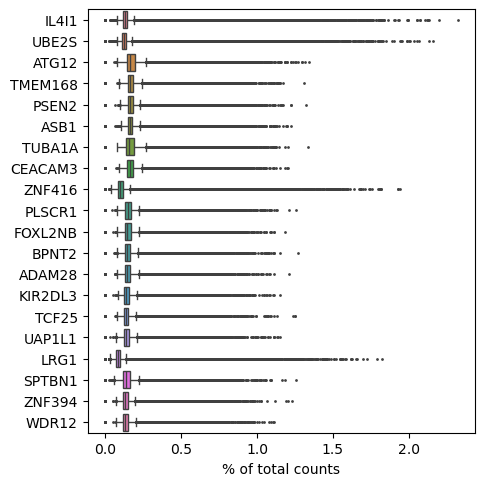

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Clustering and Low-Dimensional Representation

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)
running Leiden clustering


/tmp/ipykernel_2048542/2816787755.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


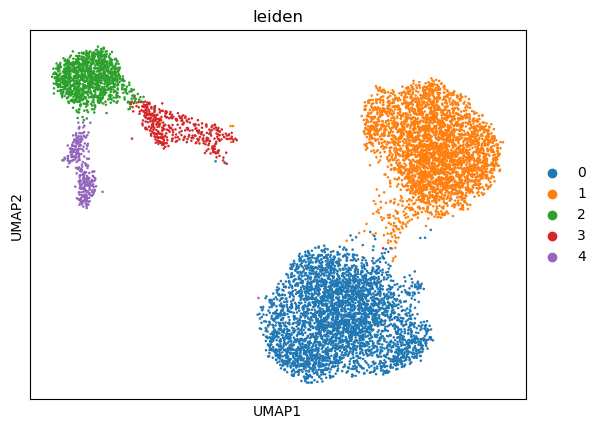

In [8]:
sc.pp.highly_variable_genes(adata)

sc.pp.pca(adata)
              
sc.pp.neighbors(
    adata, 
)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, 
    resolution=0.3, 
)

sc.pl.umap(adata, 
          color=['leiden'])

In [9]:
adata.obs.columns

Index(['n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden'],
      dtype='object')

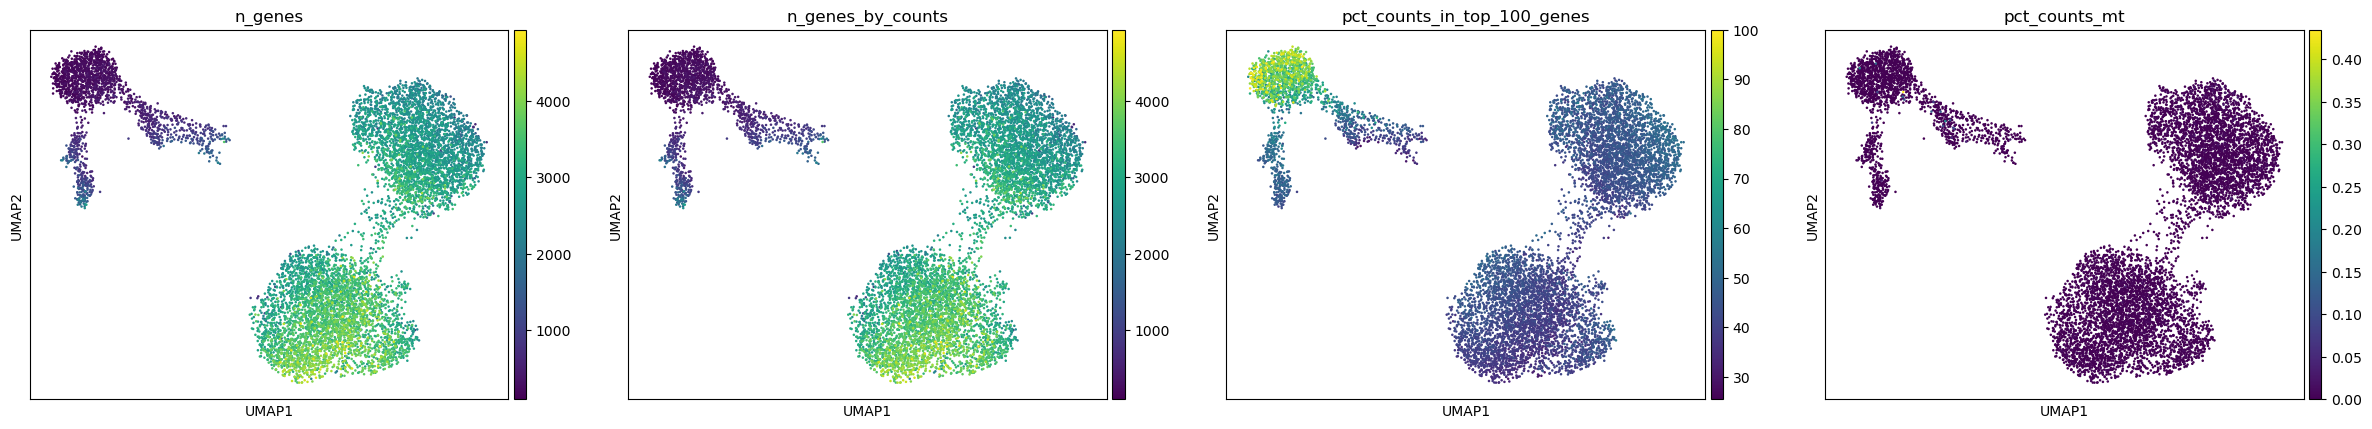

In [10]:
sc.pl.umap(adata, 
          color=['n_genes', 
                 'n_genes_by_counts', 
                 'pct_counts_in_top_100_genes', 
                 'pct_counts_mt'])

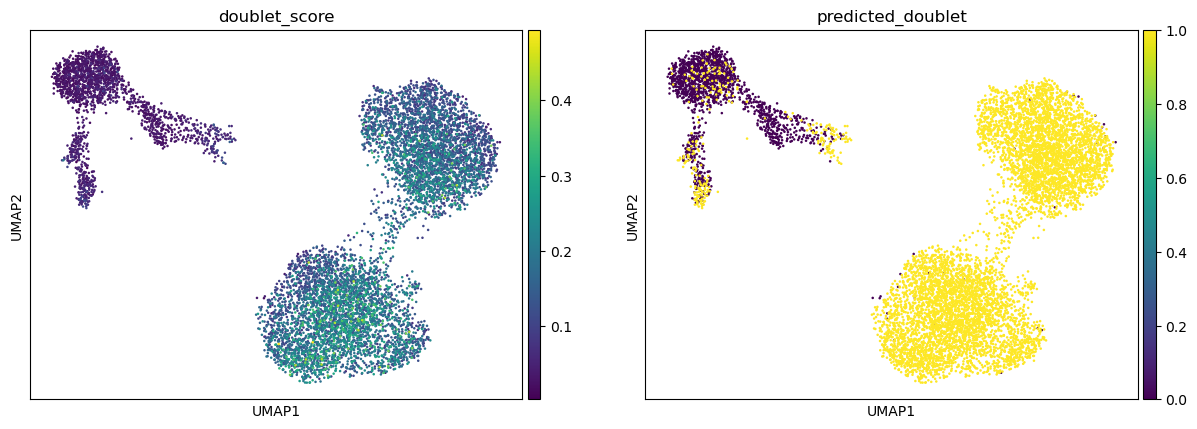

In [11]:
sc.pl.umap(adata, 
          color=['doublet_score', 
                 'predicted_doublet',])

# DEG

In [12]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="leiden",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None
)

deg.head()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


group    names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
0     0     APIP  72.497490        3.011627    0.0        0.0      0.999470   
1     0  ADAMTS8  72.338203        4.311616    0.0        0.0      0.987016   
2     0    DCDC1  72.149498        4.070561    0.0        0.0      0.990991   
3     0     ADH6  71.969337        3.633376    0.0        0.0      0.985957   
4     0     DKK2  71.836708        4.620574    0.0        0.0      0.990461   

   pct_nz_reference  
0          0.677141  
1          0.211535  
2          0.315769  
3          0.267867  
4          0.190458

# Enrichment Analysis

In [13]:
n_genes = 100
pvals_adj = 0.05
logfoldchanges = 0.0
pct_nz_group = 0.3
database = 'ontology'

# --- Filtering the Data --- 
print(f"\nFiltering differentially expressed genes (DEG) based on the following criteria:")
print(f"  - Adjusted p-value <= {pvals_adj}")
print(f"  - Log fold change >= {logfoldchanges}")
print(f"  - Percent of non-zero values in group >= {pct_nz_group}")

sig = deg.copy()
sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] >= logfoldchanges]
sig = sig[sig['pct_nz_group'] >= pct_nz_group]
sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

# --- Enrichment Analysis ---
print("\nPerforming enrichment analysis on the filtered DEG list using the Enrichr database...")

for group_name, group in sig.groupby('group'):

    print(f"\n\n--- Results for Group: {group_name} ---\n") 

    gene_list = group['names'].head(n_genes).to_list()

    edf = gget.enrichr(gene_list, database=database)
    columns = ['path_name', 'adj_p_val', 'overlapping_genes']

    pd.set_option('display.max_colwidth', 100)
    print(edf[columns].head().to_string(index=False)) # Nicely formatted output

    # break # Process only the first group


Filtering differentially expressed genes (DEG) based on the following criteria:
  - Adjusted p-value <= 0.05
  - Log fold change >= 0.0
  - Percent of non-zero values in group >= 0.3


Tue Sep  3 17:12:40 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



Performing enrichment analysis on the filtered DEG list using the Enrichr database...


--- Results for Group: 0 ---



Tue Sep  3 17:12:41 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


                                                path_name  adj_p_val               overlapping_genes
                           protein acylation (GO:0043543)   0.283012       [ZDHHC18, NAT10, ZDHHC13]
                 actin filament organization (GO:0007015)   0.283012 [ENAH, GHSR, GAS2, RHOA, LMOD3]
midbrain dopaminergic neuron differentiation (GO:1904948)   0.283012                   [FZD1, LMX1A]
   regulation of cellular component movement (GO:0051270)   0.283012             [CDK6, ARAP1, RHOA]
      regulation of interleukin-6 production (GO:0032675)   0.283012  [GHSR, TYROBP, MAPKAPK2, GAS6]


--- Results for Group: 1 ---



Tue Sep  3 17:12:42 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


                                                                   path_name  adj_p_val     overlapping_genes
                          regulation of RNA export from nucleus (GO:0046831)   0.305433        [SETD2, CPSF6]
                  positive regulation of sprouting angiogenesis (GO:1903672)   0.305433        [S100A1, FGF2]
 establishment of protein localization to endoplasmic reticulum (GO:0072599)   0.305433     [SPCS3, RAB3GAP1]
homophilic cell adhesion via plasma membrane adhesion molecules (GO:0007156)   0.305433    [CDH1, PALLD, PVR]
                           cellular response to nutrient levels (GO:0031669)   0.305433 [LAMP2, RRAGD, VPS41]


--- Results for Group: 2 ---



Tue Sep  3 17:12:42 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


                                                                                 path_name  adj_p_val                               overlapping_genes
                             regulation of transcription by RNA polymerase II (GO:0006357)   0.032734 [IL4I1, ZNF418, ZNF416, ZFP82, ZNF552, ZNF585A]
erythrose 4-phosphate/phosphoenolpyruvate family amino acid catabolic process (GO:1902222)   0.032734                                         [IL4I1]
                                            L-phenylalanine catabolic process (GO:0006559)   0.032734                                         [IL4I1]
                                          free ubiquitin chain polymerization (GO:0010994)   0.032734                                         [UBE2S]
erythrose 4-phosphate/phosphoenolpyruvate family amino acid metabolic process (GO:1902221)   0.032734                                         [IL4I1]


--- Results for Group: 3 ---



Tue Sep  3 17:12:43 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


                                                              path_name  adj_p_val overlapping_genes
  positive regulation of regulatory T cell differentiation (GO:0045591)   0.277725   [IL4I1, DUSP10]
                      peptidyl-threonine dephosphorylation (GO:0035970)   0.277725   [DUSP10, PPM1F]
           regulation of regulatory T cell differentiation (GO:0045589)   0.277725   [IL4I1, DUSP10]
positive regulation of cytokine-mediated signaling pathway (GO:0001961)   0.277725  [TICAM2, AGPAT2]
                            transition metal ion transport (GO:0000041)   0.277725   [MELTF, ATP2C1]


--- Results for Group: 4 ---

                                                          path_name  adj_p_val        overlapping_genes
positive regulation of long-term synaptic potentiation (GO:1900273)   0.024459       [APP, ZDHHC2, INS]
                                  acute-phase response (GO:0006953)   0.024459      [PLSCR1, AHSG, INS]
                           acute inflammatory resp

# Plotting

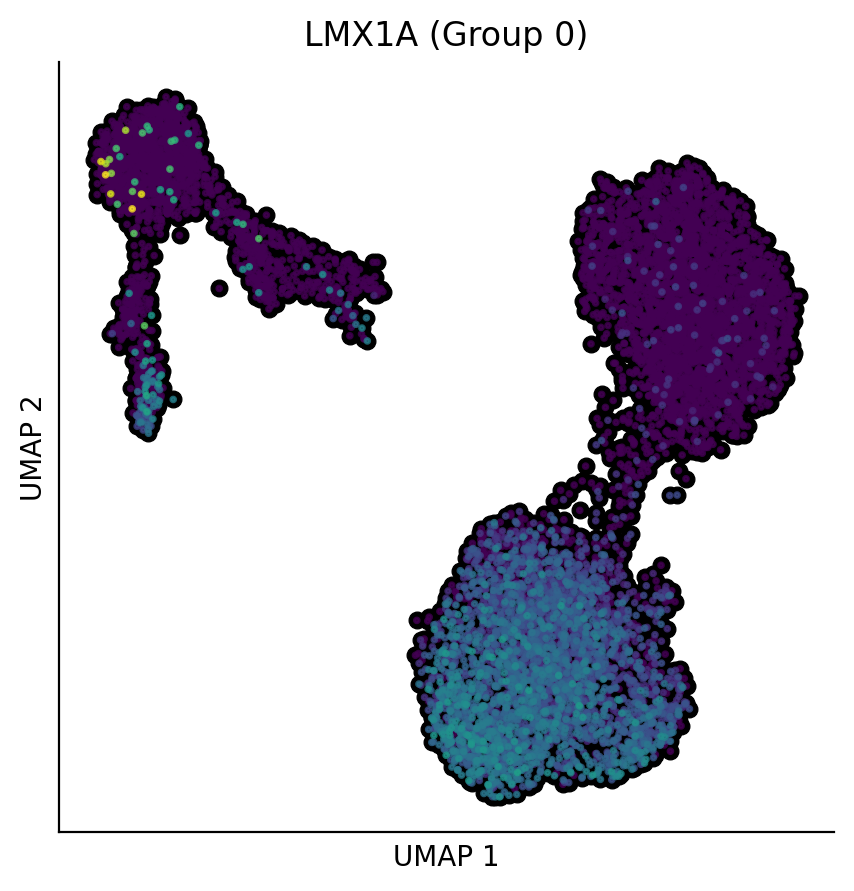

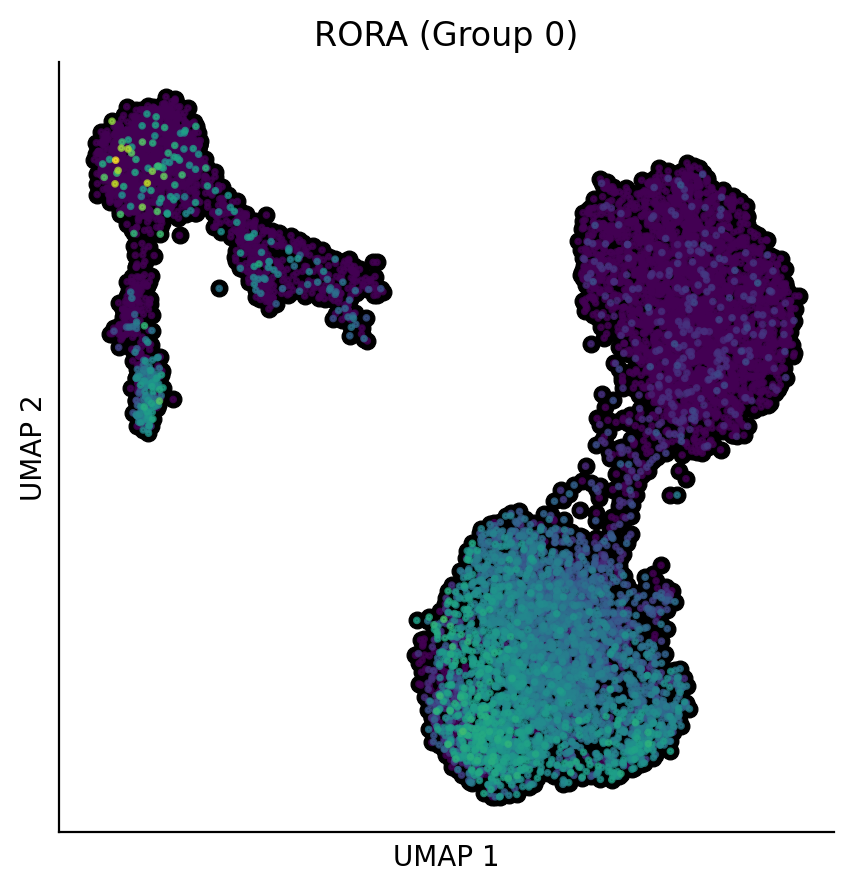

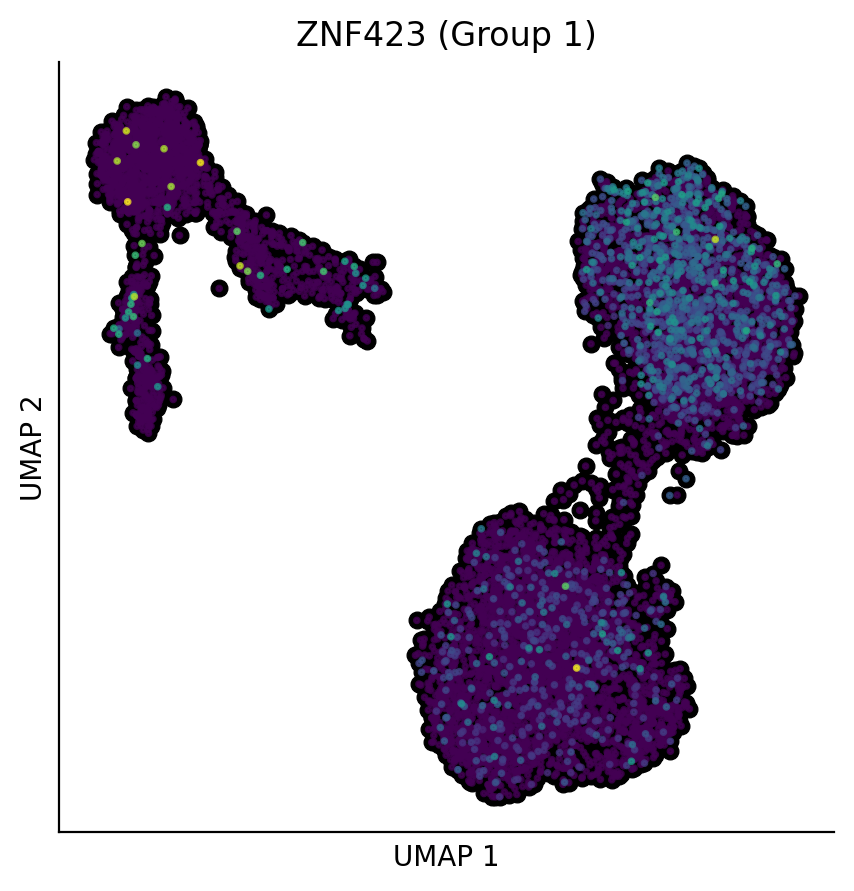

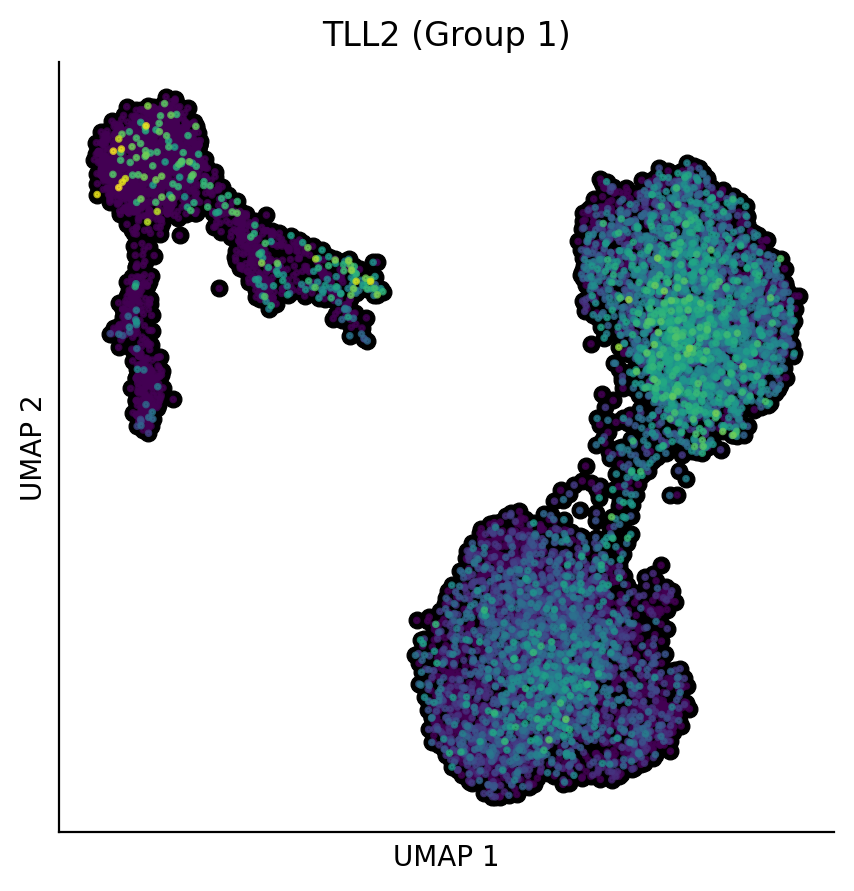

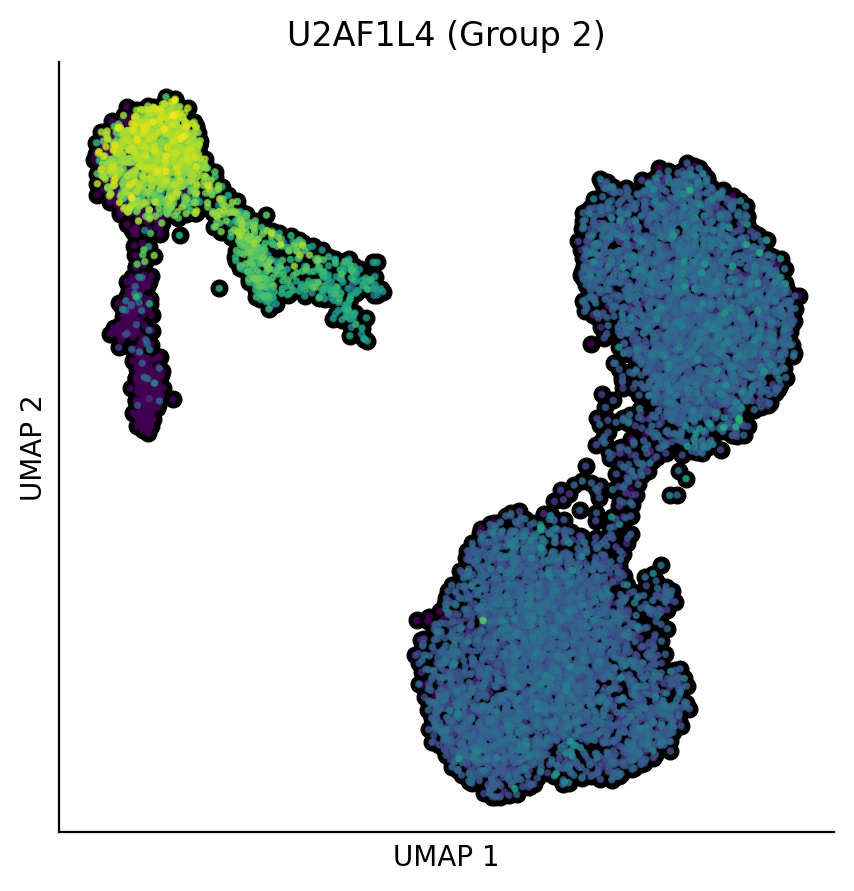

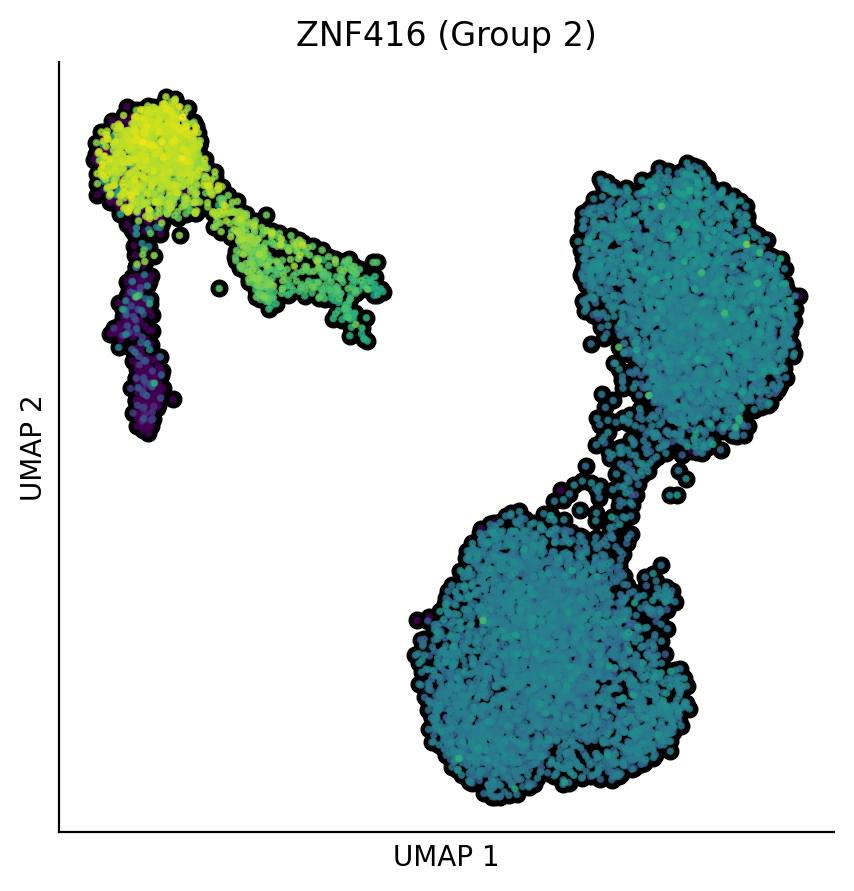

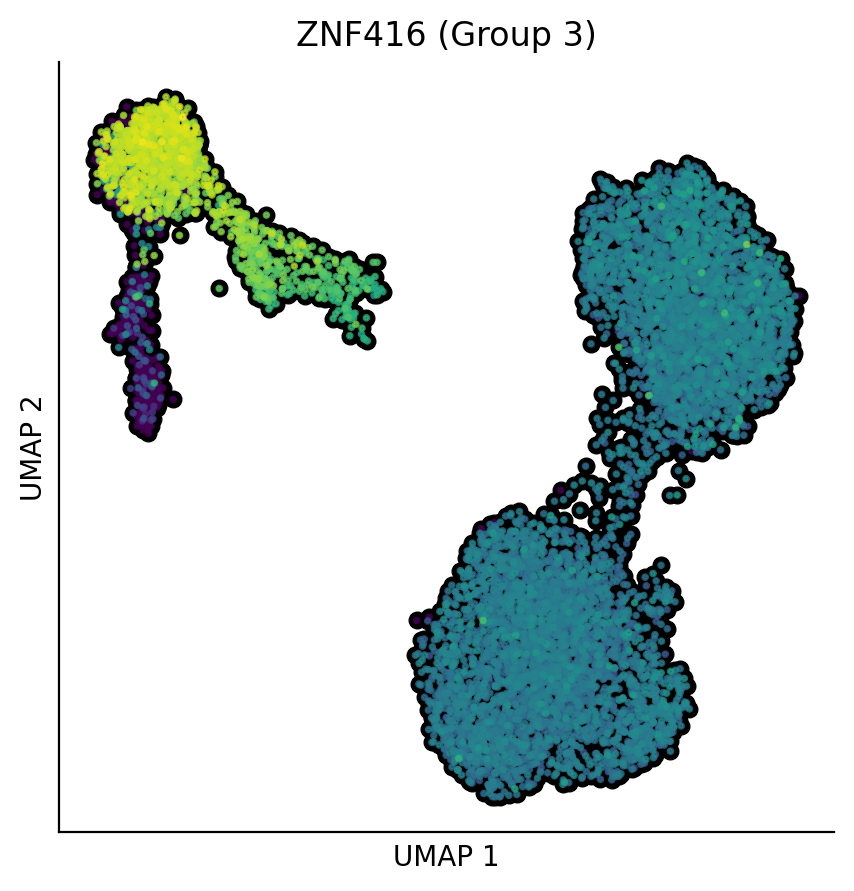

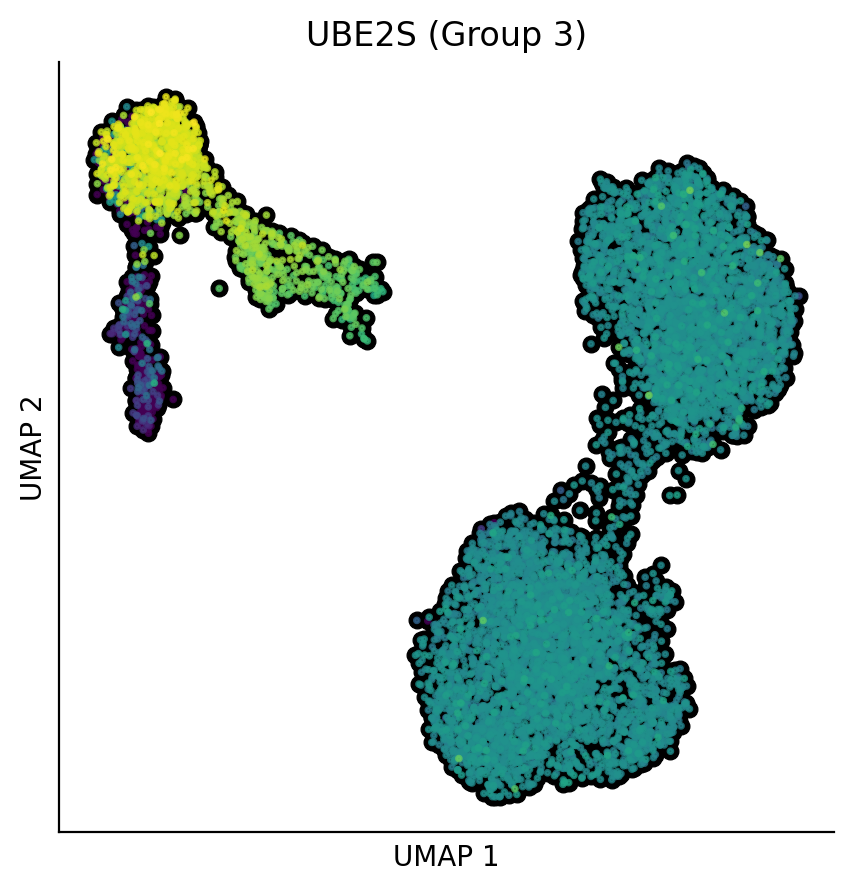

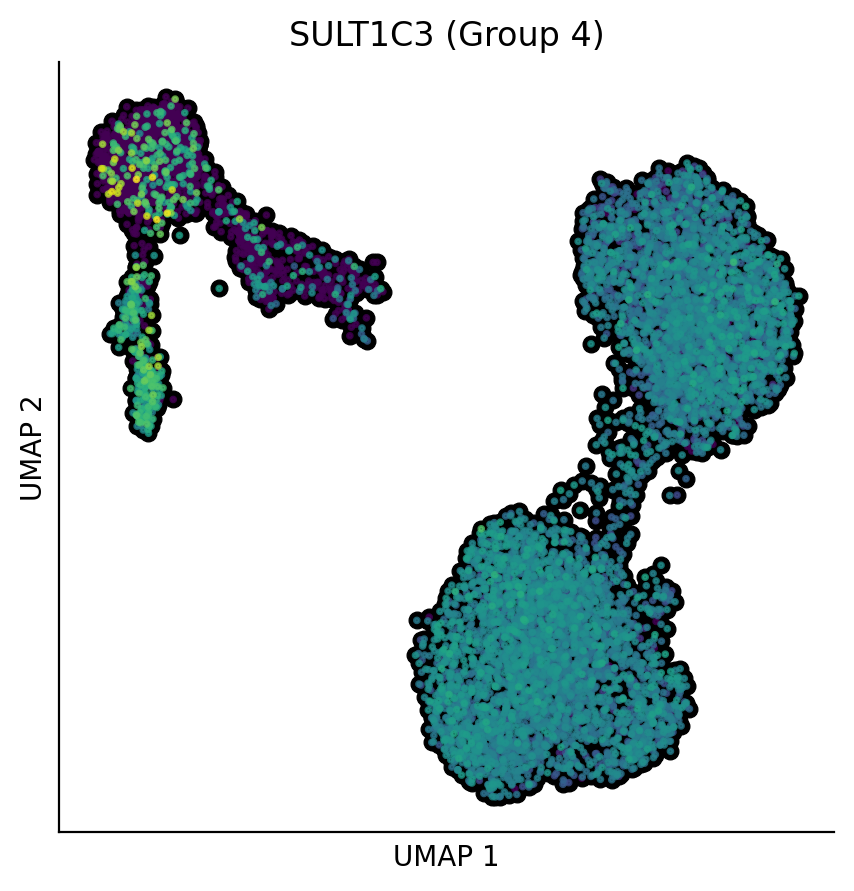

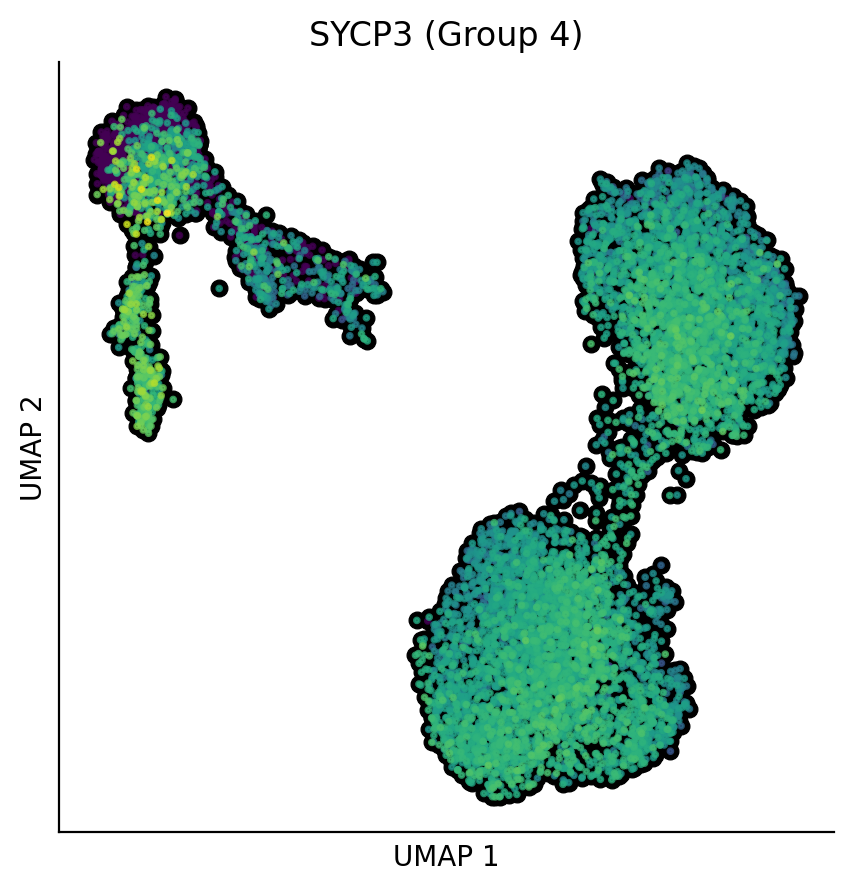

In [14]:
n_genes = 2
pvals_adj = 0.05
logfoldchanges = 1.0
pct_nz_group = 0.3

sig = deg.copy()
sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] >= logfoldchanges]
sig = sig[sig['pct_nz_group'] >= pct_nz_group]
sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

sig = sig.groupby('group').head(n_genes)


for _, row in sig.iterrows():
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 5, 5
    
    x = adata.obsm['X_umap'][:, 0]
    y = adata.obsm['X_umap'][:, 1]
    
    sns.scatterplot(
        adata.obs,
        x=x,
        y=y,
        ec='k',
        c='k',
    )
    
    # plot the gene expression
    gene = row['names']
    z = adata[:, gene].to_df()[gene].values
    sorted_idx = np.argsort(z)
    
    plt.scatter(
        x[sorted_idx],
        y[sorted_idx],
        c=z[sorted_idx],
        s=3,
        alpha=0.75,
    )
    
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    
    sns.despine()
    
    plt.title(f"{gene} (Group {row['group']})")
    plt.show()


# cell cycle genes

In [15]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/go_cell_cycle_genes/human_cell_cycle_genes.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")
df = df[df['gene_name'].isin(adata.var_names)]
print(f"{df.shape=}")
df = df.set_index('gene_name')
df.head()

df.shape=(142, 7)
df.shape=(94, 7)


G1 Phase  G1/S Transition Checkpoint Signaling  G2 Phase  \
gene_name                                                             
ABCB1         False                                 False     False   
ACVR1B        False                                  True     False   
AMBRA1        False                                  True     False   
APP           False                                 False     False   
ARPP19        False                                 False     False   

           G2/M Transition Checkpoint Signaling  M Phase  S Phase  
gene_name                                                          
ABCB1                                      True    False    False  
ACVR1B                                    False    False    False  
AMBRA1                                    False    False    False  
APP                                        True    False    False  
ARPP19                                     True    False    False

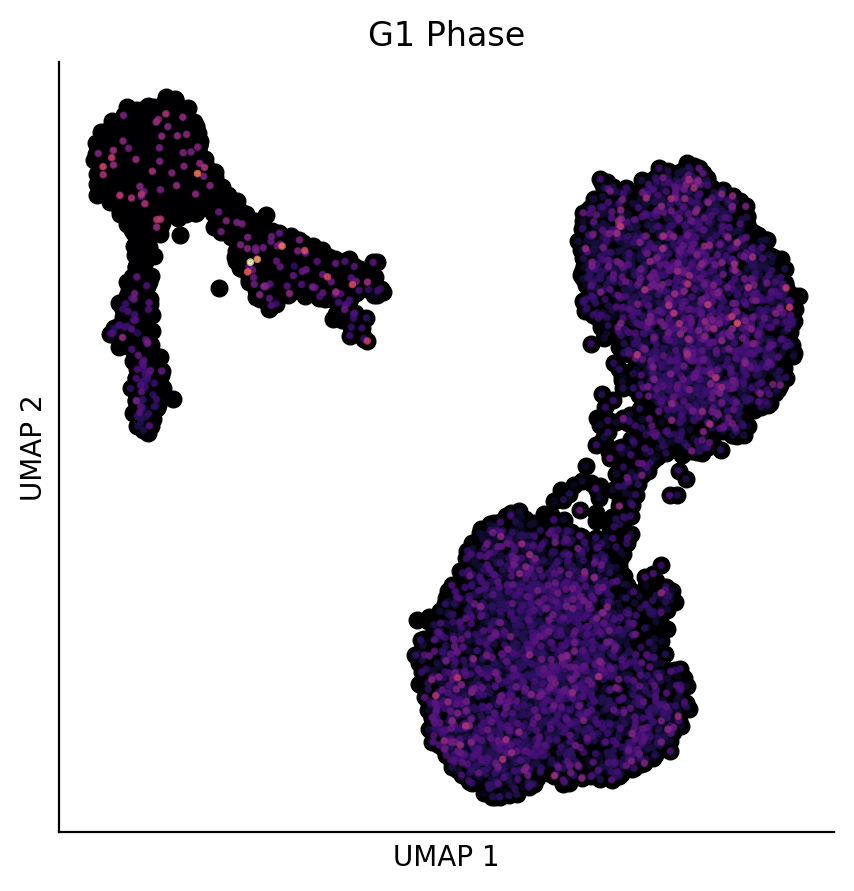

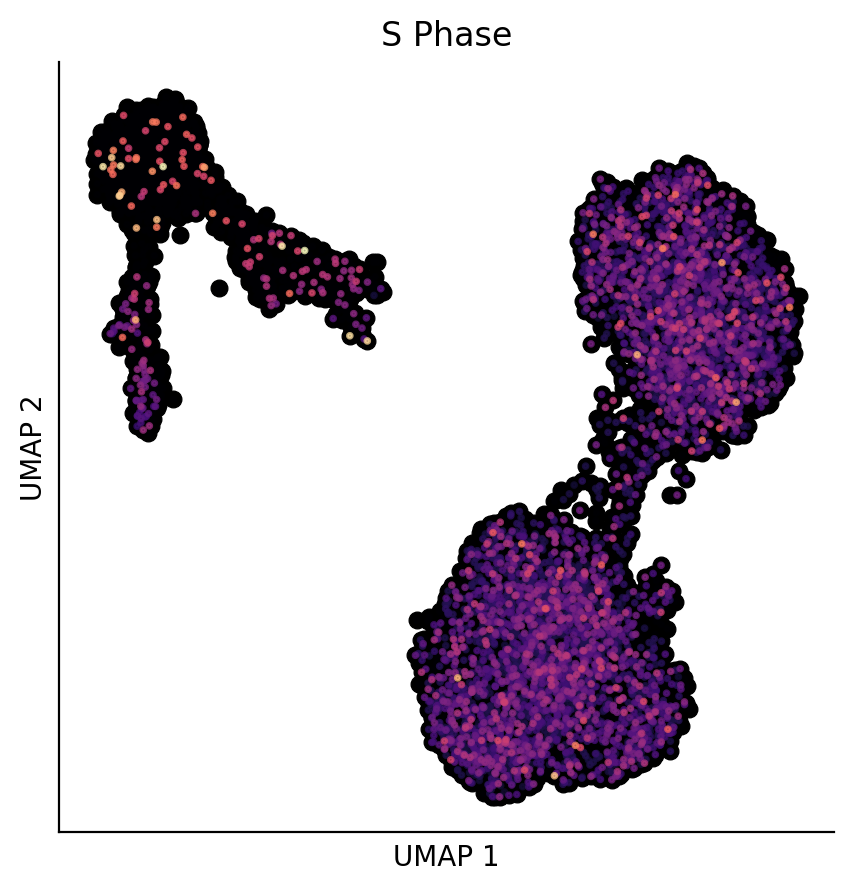

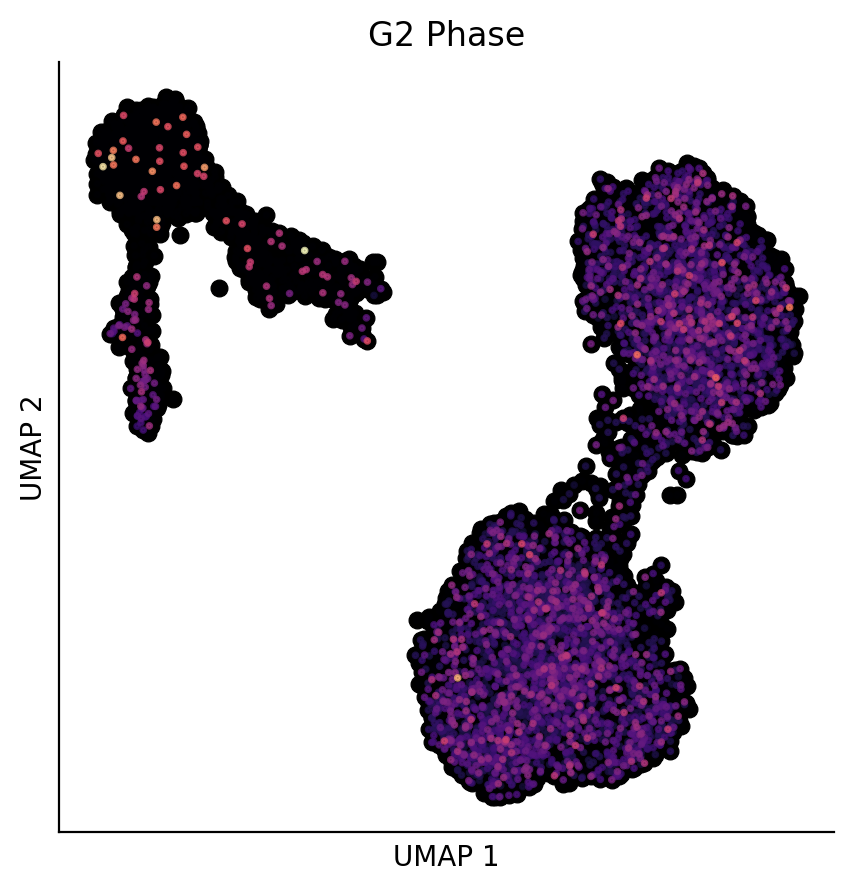

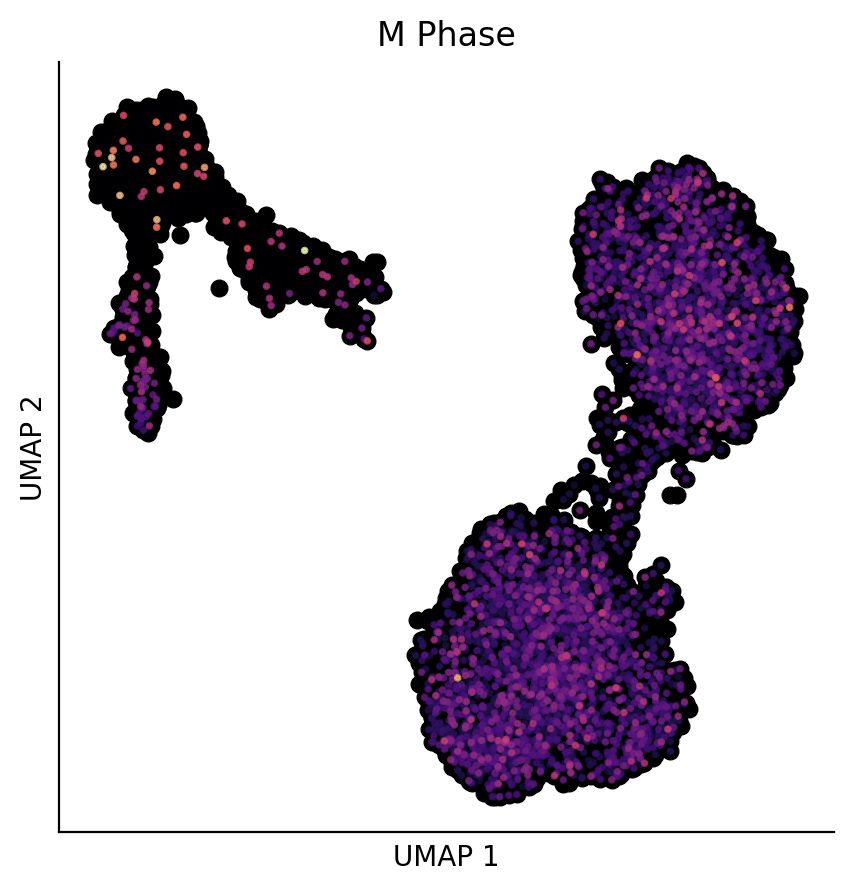

In [16]:
phases = [
    'G1 Phase',
    'S Phase',
    'G2 Phase',
    'M Phase', 
]

for phase in phases:
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 5, 5
    
    x = adata.obsm['X_umap'][:, 0]
    y = adata.obsm['X_umap'][:, 1]
    
    sns.scatterplot(
        adata.obs,
        x=x,
        y=y,
        ec='k',
        c='k',
    )
    
    # get mean expression of cell cycle genes
    phase_genes = df[df[phase]].index.to_list()
    phase_genes = [x for x in phase_genes if x in adata.var_names]
    z = adata[:, phase_genes].to_df().mean(axis=1).values
    sorted_idx = np.argsort(z)
    
    plt.scatter(
        x[sorted_idx],
        y[sorted_idx],
        c=z[sorted_idx],
        s=3,
        alpha=0.75,
        cmap='magma',
    )
    
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    
    sns.despine()
    
    plt.title(f"{phase}")
    plt.show()

# recluster on cell cycle genes

In [17]:
gene_list = df.index.to_list()
gene_list = [x for x in gene_list if x in adata.var_names]

adata.var['cell_cycle'] = adata.var.index.isin(gene_list)
adata.var['cell_cycle'].value_counts()

cell_cycle
False    14466
True        94
Name: count, dtype: int64

In [18]:
adata.var.head()

gene_name Chromosome     Start       End Strand     mt   ribo     hb  \
ATAD3B    ATAD3B          1   1471764   1497848      +  False  False  False   
SKI          SKI          1   2228318   2310213      +  False  False  False   
PEX14      PEX14          1  10472287  10630758      +  False  False  False   
PLCH2      PLCH2          1   2425979   2505532      +  False  False  False   
SPSB1      SPSB1          1   9292893   9369532      +  False  False  False   

        n_cells_by_counts  mean_counts  log1p_mean_counts  \
ATAD3B               1052     0.107875           0.102443   
SKI                  3131     0.396214           0.333764   
PEX14                 380     0.037582           0.036893   
PLCH2                 483     0.047046           0.045973   
SPSB1                   3     0.000276           0.000276   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
ATAD3B              90.333548          1174            7.069023     1052   
SKI                 71.230359          4312            8.369389     3131   
PEX14               96.508316           409            6.016157      380   
PLCH2               95.561886           512            6.240276      483   
SPSB1               99.972434             3            1.386294        3   

        highly_variable     means  dispersions  dispersions_norm  cell_cycle  
ATAD3B             True  0.125015     1.784035          0.707712       False  
SKI               False  0.395819     1.346710         -0.528602       False  
PEX14             False  0.049900     1.141530         -0.128325       False  
PLCH2             False  0.061297     1.471521          0.301064       False  
SPSB1             False  0.000287    -0.144181         -1.801312       False

<Axes: xlabel='n_cells', ylabel='Count'>

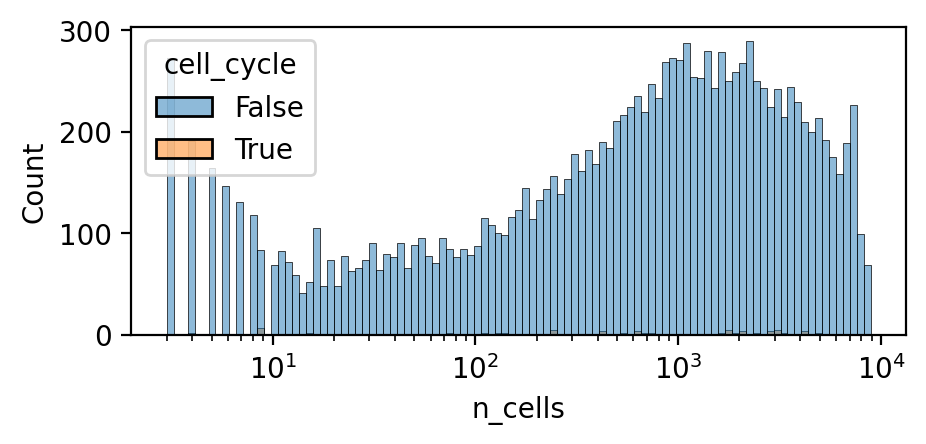

In [19]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

sns.histplot(
    adata.var, 
    x='n_cells',
    bins=101,
    log_scale=True,
    hue='cell_cycle',
    stat='count',
)

# adata.var[adata.var['cell_cycle']]

In [20]:
adata.var[adata.var['cell_cycle']].index

Index(['RHOU', 'CDC7', 'PLK3', 'KHDRBS1', 'PBX1', 'ENSA', 'IQGAP3', 'NES',
       'MTA3', 'SPDYA', 'CUL3', 'CALM2', 'TRIM71', 'CDC25A', 'DRD3', 'PPP3CA',
       'CCNA2', 'EIF4E', 'FBXL7', 'SKP2', 'CCNB1', 'CAMK2A', 'ID4', 'SYCP2L',
       'TPD52L1', 'BTN2A2', 'E2F3', 'CDKN1A', 'HBS1L', 'CCND3', 'CDK14',
       'DBF4', 'CUL1', 'CDK6', 'ABCB1', 'CCNE2', 'MELK', 'PPP6C', 'CCNY',
       'FBXL15', 'CDK1', 'ITGB1', 'CUL2', 'BRSK2', 'CUL5', 'DRD4', 'PPME1',
       'HINFP', 'CHEK1', 'CCND1', 'HSPA8', 'DRD2', 'USH1C', 'AMBRA1', 'CCND2',
       'ACVR1B', 'CDK2', 'CDKN1B', 'BCAT1', 'CDK4', 'FOXM1', 'POLE', 'CUL4A',
       'RGCC', 'LATS2', 'CDKN3', 'CALM1', 'GPR132', 'PIAS1', 'ARPP19', 'LCMT1',
       'TERF2IP', 'PLK1', 'TERF2', 'RPS6KB1', 'PPM1D', 'CDK3', 'USP22',
       'CCNE1', 'BRSK1', 'CDC34', 'DNM2', 'ZNF324', 'USP29', 'PLCB1', 'CDC25B',
       'SYCP2', 'AURKA', 'APP', 'FBXO7', 'CHEK2', 'CUL4B', 'PHF8', 'PIM2'],
      dtype='object')

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 4 clusters and added
    'cell_cycle_clusters', the cluster labels (adata.obs, categorical) (0:00:00)


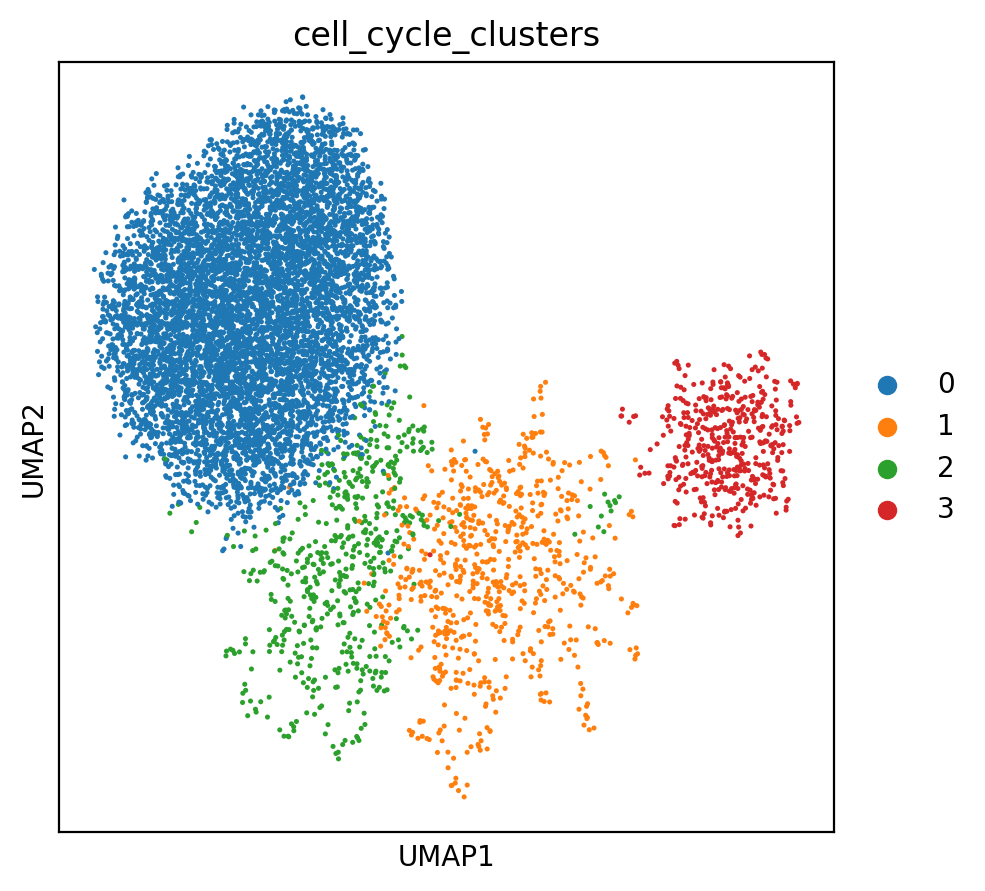

In [22]:
sc.pp.pca(
    adata,
    mask_var='cell_cycle',
)
              
sc.pp.neighbors(
    adata,
    n_neighbors=7,
)

sc.tl.umap(
   adata,
    min_dist=1.0,
)

sc.tl.leiden(
   adata,
    resolution=0.3, 
    key_added='cell_cycle_clusters'
)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    adata, 
    color=['cell_cycle_clusters'],
)

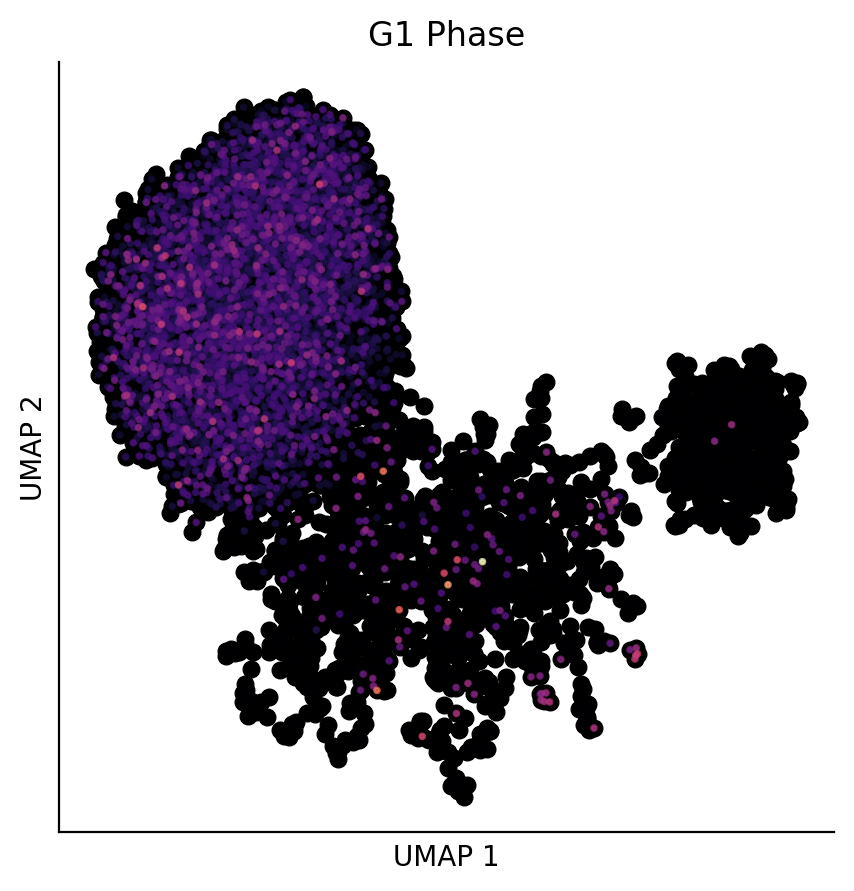

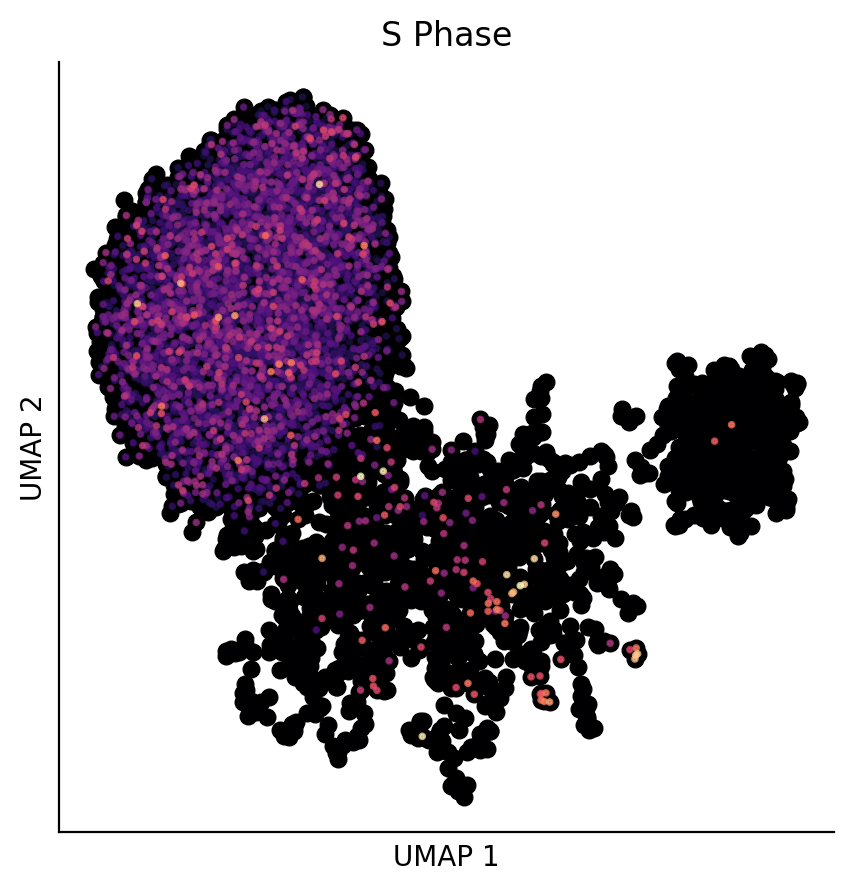

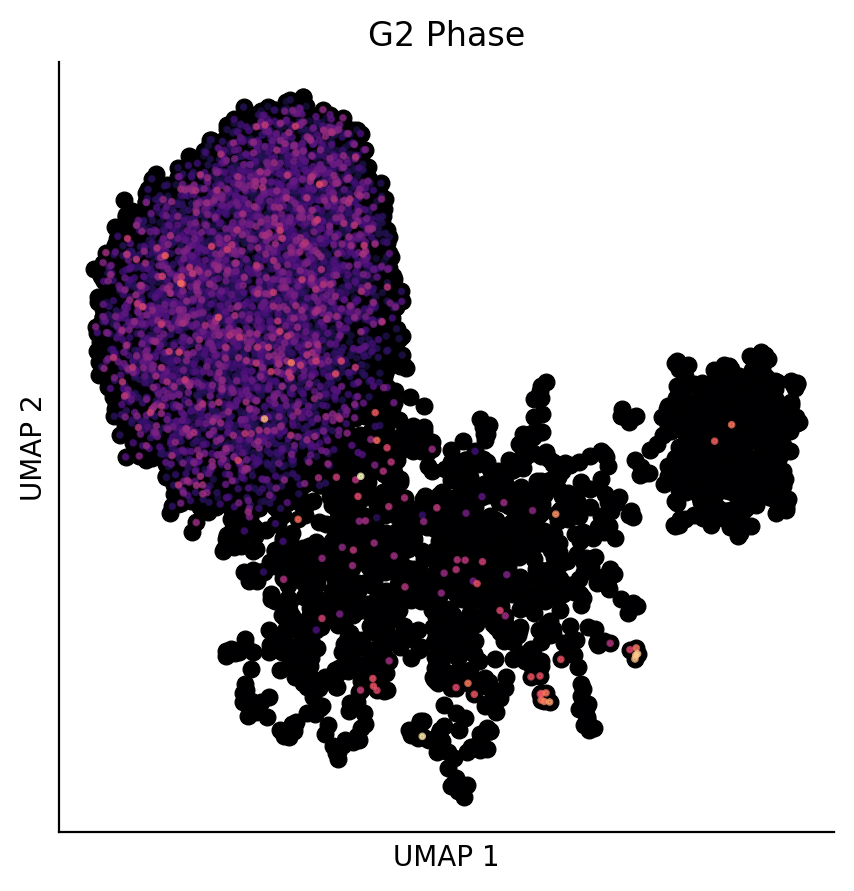

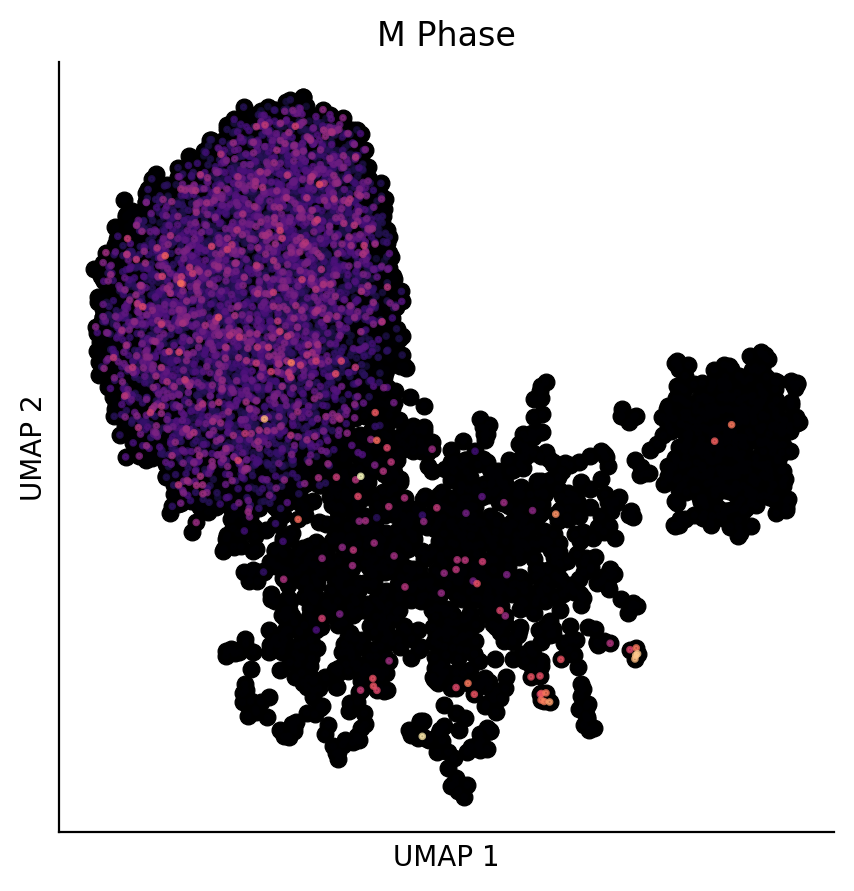

In [23]:
phases = [
    'G1 Phase',
    'S Phase',
    'G2 Phase',
    'M Phase', 
]

for phase in phases:
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 5, 5
    
    x = adata.obsm['X_umap'][:, 0]
    y = adata.obsm['X_umap'][:, 1]
    
    sns.scatterplot(
        adata.obs,
        x=x,
        y=y,
        ec='k',
        c='k',
    )
    
    # get mean expression of cell cycle genes
    phase_genes = df[df[phase]].index.to_list()
    phase_genes = [x for x in phase_genes if x in adata.var_names]
    z = adata[:, phase_genes].to_df().mean(axis=1).values
    sorted_idx = np.argsort(z)
    
    plt.scatter(
        x[sorted_idx],
        y[sorted_idx],
        c=z[sorted_idx],
        s=3,
        alpha=0.75,
        cmap='magma',
    )
    
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    
    sns.despine()
    
    plt.title(f"{phase}")
    plt.show()